# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam
    
За все три задания 1 бал, срок выполнения 2 недели, после 0.5 бала.

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку pytorch. Получаем на вход тензор размером $(B, C_{in}, H, W)$, на выходе получаем тензор $(B, C_{out}, H_{out}, W_{out})$.
$$
B \ - \ размерность\ батча. \\
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки:
$$
\begin{equation*}
\text{out}(B_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{kernel}(C_{out_j}, k) \star \text{x}(B_i, k)
\end{equation*},
$$

где $\large k $ - ядро свертки, с парамерами $C_{in}, H_k, W_k, stride_{H,W}, padding_{H,W}  $.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [613]:
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d (или 4d если несколько фильров), тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда
    :param  padding:  tuple - параметры паддинга
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    
    h_out = (x.shape[1] + 2*padding[0] - kernel.shape[1])/stride[0] + 1
    w_out = (x.shape[2] + 2*padding[1] - kernel.shape[2])/stride[1] + 1
    
    if h_out%1 != 0 or w_out%1 != 0:
        raise ValueError('Your h_out or w_out values are not intgers. Please check stride and padding settings', [h_out, w_out])
    
    out = torch.FloatTensor(int(h_out),int(w_out)).fill_(0)
    
    if padding[0] != 0 and padding[1] != 0:
        padding_x = torch.FloatTensor(x.shape[0], x.shape[1] + 2*padding[0], x.shape[2] + 2*padding[1]).fill_(0)
        padding_x[:,padding[0]:padding_x.shape[1]-padding[0],padding[1]:padding_x.shape[2]-padding[1]] = x
        x = padding_x
        
    if len(kernel.shape) == 3 and (kernel.shape[0] == 1 or kernel.shape[0] == x.shape[0]): 
        for i, x_coord in enumerate(range(0,x.shape[1] - kernel.shape[1] + 1, stride[0])):
            for j, y_coord in enumerate(range(0,x.shape[2] - kernel.shape[2] + 1, stride[1])):
                window = x[:,x_coord:x_coord+kernel.shape[1], y_coord:y_coord+kernel.shape[2]]
                try:
                    out[i,j] += torch.sum(window*kernel)
                except:
                    print(i,j)
                    print(x_coord,y_coord)
                    print(out.shape)
                    print(x.shape)
                    print(window.shape)
                    print(kernel.shape)
                    raise ValueError()
                    
    elif len(kernel.shape) == 4 and (kernel.shape[1] == 1 or kernel.shape[1] == x.shape[0]):
        print('Several filters:', kernel.shape[0])
        out = torch.FloatTensor(kernel.shape[0],int(h_out),int(w_out)).fill_(0)
        for i, x_coord in enumerate(range(0,x.shape[1] - kernel.shape[1] + 1, stride[0])):
            for j, y_coord in enumerate(range(0,x.shape[2] - kernel.shape[2] + 1, stride[1])):
                window = x[:,x_coord:x_coord+kernel.shape[1], y_coord:y_coord+kernel.shape[2]]
                try:
                    for fltr in range(kernel.shape[0]):
                        out[fltr,i,j] += torch.sum(window*kernel[fltr])
                except:
                    print(i,j)
                    print(x_coord,y_coord)
                    print(out.shape)
                    print(x.shape)
                    print(window.shape)
                    print(kernel.shape)
                    raise ValueError()
    else:
        raise ValueError('Please check your kernel settings', kernel.shape, x.shape)
        
    if bias != None:
        return out + bias
    return out

## Тестируем функцию свертки

### Загружаем картинку 

(560, 372)


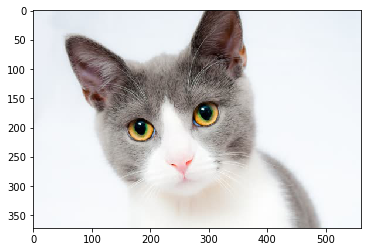

In [2]:
import torch
import numpy as np
import torchvision as tv
from torch.nn.functional import conv2d

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
print(cat_convolve.size)
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [656]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
#cat_tensor = cat_tensor.unsqueeze(0)
print (cat_tensor.size())

torch.Size([3, 372, 560])


In [616]:
cat_tensor

tensor([[[0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
         [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
         [0.9137, 0.9137, 0.9137,  ..., 0.9098, 0.9098, 0.9098],
         ...,
         [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
         [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
         [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725]],

        [[0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
         [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
         [0.9333, 0.9333, 0.9333,  ..., 0.9373, 0.9373, 0.9373],
         ...,
         [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
         [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765],
         [0.9725, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9765]],

        [[0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
         [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
         [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.

### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [492]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

(370, 558)


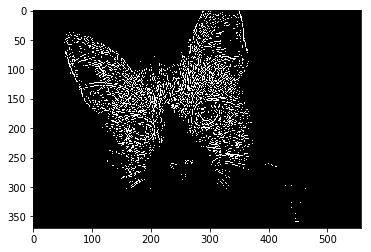

In [484]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image = o_image.numpy()
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.shape)
plt.imshow(o_image, cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [487]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


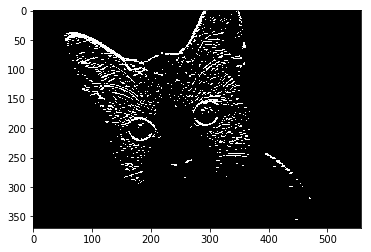

In [488]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [502]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


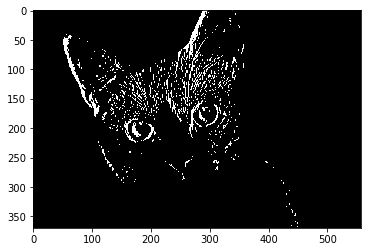

In [503]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])


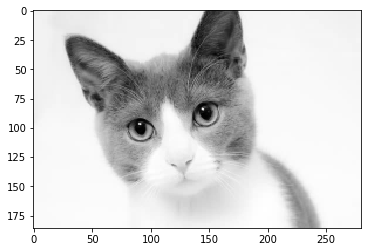

In [498]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

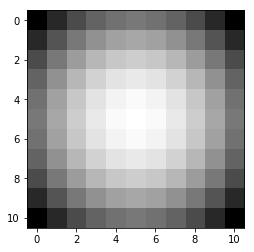

In [499]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])


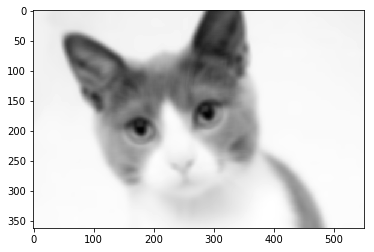

In [584]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

In [702]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        self.in_channels = in_channels
        self.afine = afine
        self.beta = beta
        self.epsilon = epsilon
        self.runing_mean = torch.zeros(in_channels)
        self.runing_var = torch.ones(in_channels)
        self.gamma = torch.ones(in_channels).uniform_()
        self.b = torch.ones(in_channels).uniform_()
        self.training = False

        pass
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
        bn_x = x.clone()
        if self.training:
            for i in range(self.in_channels):
                self.runing_mean[i] = self.beta*self.runing_mean[i] + (1-self.beta)*torch.mean(x[:,i,:,:])
                self.runing_var[i] = self.beta*self.runing_var[i] + (1-self.beta)*torch.var(x[:,i,:,:])
        if self.afine == True:
            for i in range(self.in_channels):
                bn_x[:,i,:,:] = (x[:,i,:,:] - self.runing_mean[i])/(self.runing_var[i] + self.epsilon) * self.gamma[i] + self.b[i]
        else:
            for i in range(self.in_channels):
                bn_x[:,i,:,:] = (x[:,i,:,:] - self.runing_mean[i])/(self.runing_var[i] + self.epsilon) 
        return bn_x


### Проверяем работу батч нормадлизации на котэ

torch.Size([3, 372, 560])


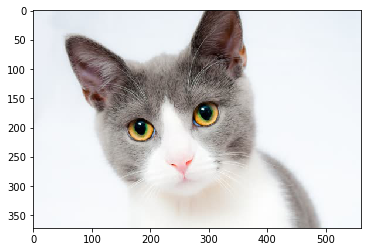

In [703]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

In [704]:
bn.b

tensor([0.6127, 0.9189, 0.5514])

In [705]:
gamma = torch.ones(3).uniform_()
b = torch.ones(3).uniform_()
gamma

tensor([0.2832, 0.7451, 0.5646])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


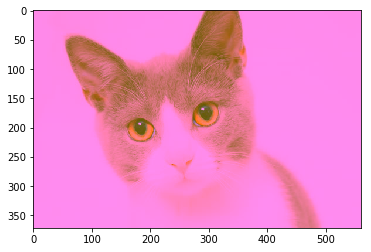

In [706]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок

In [47]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [48]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


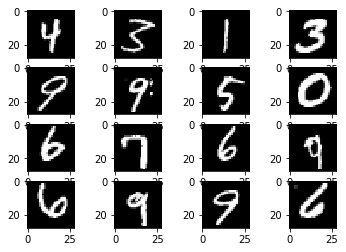

In [49]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [719]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ np.mean(bn.runing_mean.numpy()) ] 
            var_curve +=  [ np.mean(bn.runing_var.numpy()) ]
    return mean_curve, var_curve

In [720]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

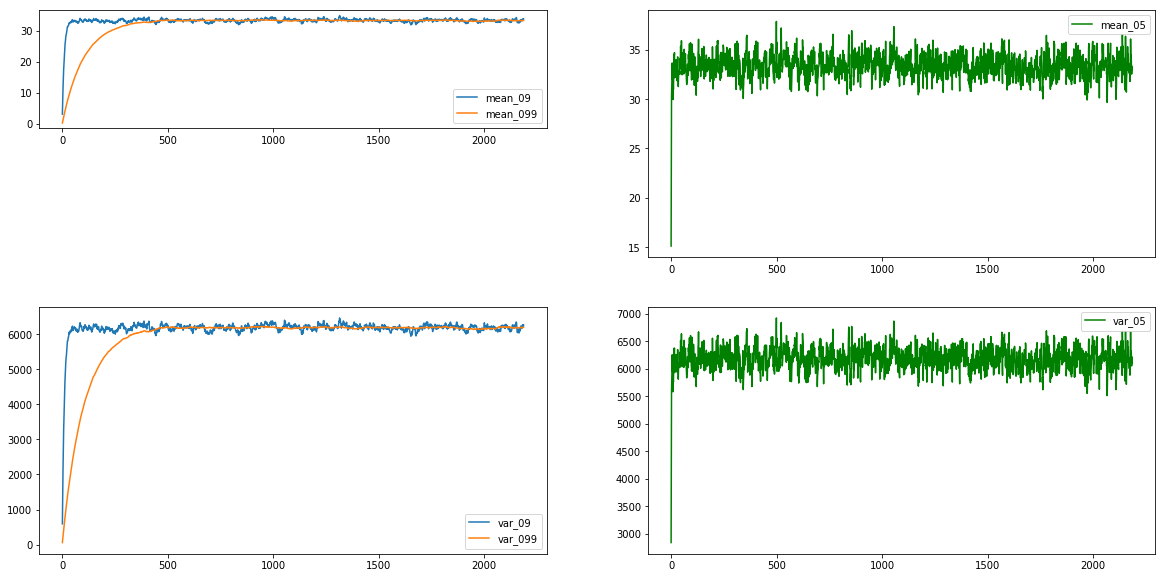

In [721]:
plt.figure(figsize=(20,10))
ax = plt.subplot(4,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

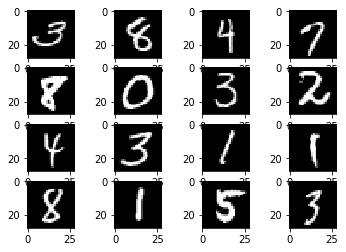

In [723]:
n=4
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [134]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] # betas
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
                # сами параметры для обновления лежат тут
                # p.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = torch.zeros_like(p.data) # нужно проинициализировать TODO
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = torch.zeros_like(p.data) # нужно проинициализировать TODO

                # тут можем достать сохраненные состояния
                exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                # TODO
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                
                step_size = lr * math.sqrt(1 - beta2 ** state['step']) / (1 - beta1 ** state['step'])

                p.data.addcdiv_(-step_size, exp_avg, exp_avg_sq.sqrt().add(eps))
                

        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [135]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # gradient                                
                grad = p.grad.data
                
                if beta != 0:
                    state = self.state[p]
                    
                    if len(state) == 0:
                        # скользящее среднее по градинтам
                        exp_avg = state['avg'] = torch.zeros_like(p.data)
                        exp_avg.mul_(beta).add_(grad)
                    else:
                        exp_avg = state['avg']
                        exp_avg.mul_(beta).add_(1 - beta, grad)
                    grad = exp_avg
                    # тут добавляем момент если он указан
                    # todo

                # обновляем веса
                # to do
                # p.data
                p.data.add_(-lr, grad)

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [136]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [137]:
USE_CUDA=True

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            

        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [139]:
def fit_net(c_epoch, network, optimizer, show_loss = True):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        if show_loss == True:
            print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [146]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd = fit_net(20, net, optimizer) # обучаем сеть

C:\Users\iLeks\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.11177053761416829
Do epoch 1 with loss 0.0444921117103912
Do epoch 2 with loss 0.0338701839943318
Do epoch 3 with loss 0.029194972775518812
Do epoch 4 with loss 0.024994310998295233
Do epoch 5 with loss 0.021916366278934434
Do epoch 6 with loss 0.019708922029795253
Do epoch 7 with loss 0.01773642164675896
Do epoch 8 with loss 0.01518498040194047
Do epoch 9 with loss 0.015851655096892195
Do epoch 10 with loss 0.013822831186220207
Do epoch 11 with loss 0.012628415968246966
Do epoch 12 with loss 0.010392825789902926
Do epoch 13 with loss 0.010429407731822816
Do epoch 14 with loss 0.009284274254861247
Do epoch 15 with loss 0.008781017726231886
Do epoch 16 with loss 0.007329217200416596
Do epoch 17 with loss 0.006724831778053612
Do epoch 18 with loss 0.005982277052120144
Do epoch 19 with loss 0.007067364450181299


## SGD с моментом

In [147]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

C:\Users\iLeks\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.8962394007412222
Do epoch 1 with loss 0.6100681404109191
Do epoch 2 with loss 0.508196901838339
Do epoch 3 with loss 0.2773377142529756
Do epoch 4 with loss 0.18723913785504542
Do epoch 5 with loss 0.03172079344106745
Do epoch 6 with loss 0.02627434848948707
Do epoch 7 with loss 0.022697475744359395
Do epoch 8 with loss 0.020951949182606528
Do epoch 9 with loss 0.0184124865465694
Do epoch 10 with loss 0.017111470949230097
Do epoch 11 with loss 0.015445441944472693
Do epoch 12 with loss 0.014277005037544086
Do epoch 13 with loss 0.014029518522707141
Do epoch 14 with loss 0.012118383928636029
Do epoch 15 with loss 0.010304523283589306
Do epoch 16 with loss 0.009885723344474063
Do epoch 17 with loss 0.009276086496036784
Do epoch 18 with loss 0.008630544982874399
Do epoch 19 with loss 0.008929241317480626


## Adam

In [150]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

C:\Users\iLeks\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.15088733794635215
Do epoch 1 with loss 0.0467411510043347
Do epoch 2 with loss 0.03713554051923163
Do epoch 3 with loss 0.03074402632093833
Do epoch 4 with loss 0.02687823141498766
Do epoch 5 with loss 0.0237276705163333
Do epoch 6 with loss 0.022206955243993905
Do epoch 7 with loss 0.01955269762558865
Do epoch 8 with loss 0.01721793726924679
Do epoch 9 with loss 0.015392896624313515
Do epoch 10 with loss 0.014253493645417947
Do epoch 11 with loss 0.012749947856210605
Do epoch 12 with loss 0.012598506769035088
Do epoch 13 with loss 0.011110955485618437
Do epoch 14 with loss 0.010691368738619443
Do epoch 15 with loss 0.010012808844794625
Do epoch 16 with loss 0.009386442795865984
Do epoch 17 with loss 0.008393463658643303
Do epoch 18 with loss 0.007687333564154351
Do epoch 19 with loss 0.007683445744226663


# Кривые обучения

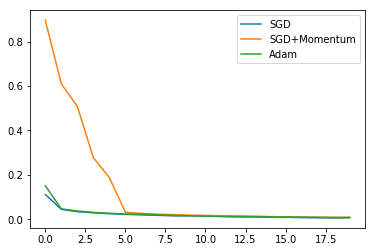

In [152]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

C:\Users\iLeks\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


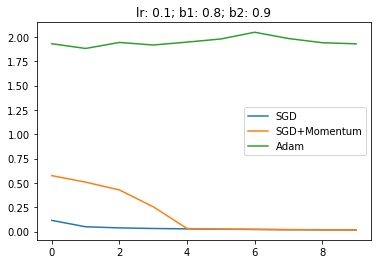

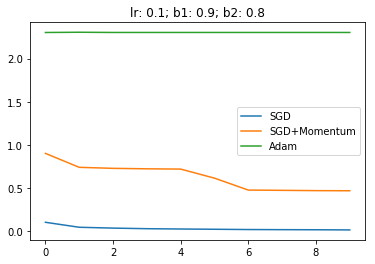

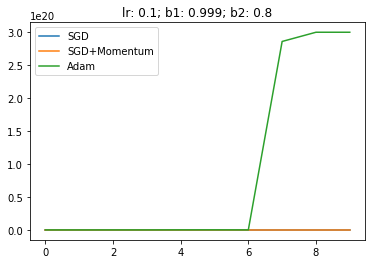

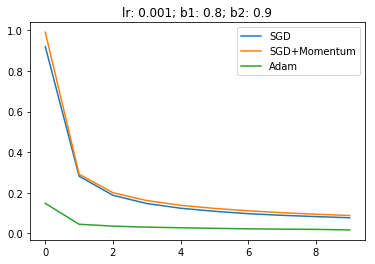

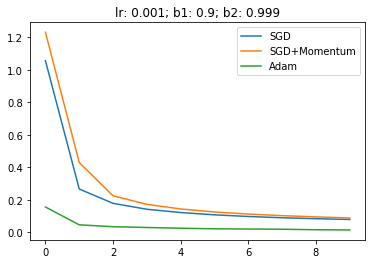

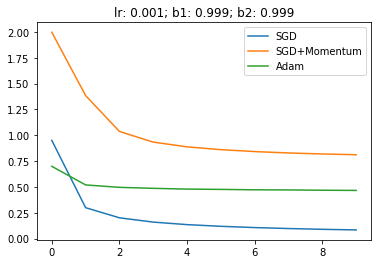

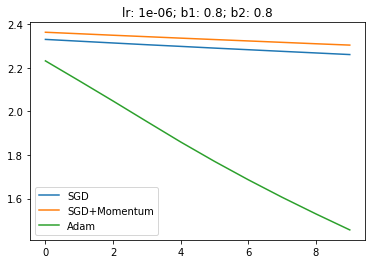

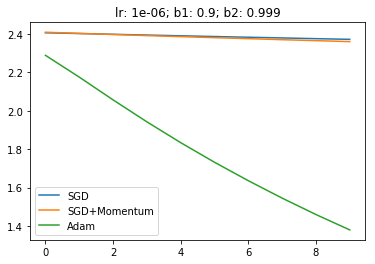

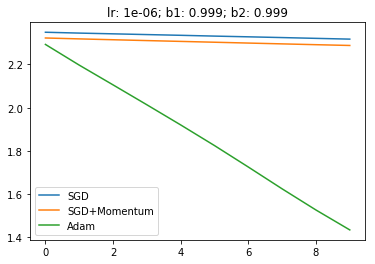

In [144]:
from random import choice

learning_rate = [1e-1, 1e-3, 1e-6]
beta1 = [0.8, 0.9, 0.999]
beta2 = [0.8, 0.9, 0.999]

for lr in learning_rate:
    for b1 in beta1:
        
        b2 = choice(beta2)
        
        net = Net(batchnorm=True)
        net = net.cuda() if USE_CUDA else net
        optimizer = Adam(net.parameters(), lr=lr, betas=(b1, b2))
        loss_curve_adam = fit_net(10, net, optimizer, show_loss = False)
        
        net = Net(batchnorm=True) # инициализация сети
        net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
        optimizer = SGD(net.parameters(), lr=lr, beta=0.0) # создаем оптимизатор с параметрами
        loss_curve_sgd = fit_net(10, net, optimizer, show_loss = False)
        
        net = Net(batchnorm=True)
        net = net.cuda() if USE_CUDA else net
        optimizer = SGD(net.parameters(), lr=lr, beta=b1)
        loss_curve_sgd_momentum = fit_net(10, net, optimizer, show_loss = False)
        
        
        ax = plt.subplot(1,1,1)
        ax.plot(loss_curve_sgd,label="SGD")
        ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
        ax.plot(loss_curve_adam, label='Adam' )
        plt.title('lr: '+ str(lr) + '; b1: '+ str(b1) + '; b2: ' + str(b2))
        ax.legend()
        plt.show()

### Выводы

_пишем выводы по сходимости и скорости обучения: Adam, SGD, SGD+momentum, с различными параметрами обучения lr и betas_

Adam не сходится при больших параметрах обучения, вероятно в следсвие нормировки на корень квадрата градиента - step_size для малых компонент градиента получается бОльшим при сравнении с SGD и SGD+momentum. При малых параметрах обучения Adam сходится много быстрее SGD и SGD+momentum, по той же причине. Оптимальные beta1 и beta2 оказались 0.9 и 0.999, соответсвенно. SGD работает предсказуемо для всех параметров обучения: быстро достигает плато при lr = 0.1 и медленно сходится к минимуму при lr = 1e-6. SGD+momentum почти при всех lr и beta показал себя хуже, чем SGD.